In [14]:
import os
import random
import numpy as np
import torch
from PIL import Image
import torchvision.transforms as T
from pathlib import Path
from tqdm import tqdm
import hdbscan
import shutil


# ======================================
# 1.  固定随机种子（可复现）
# ======================================
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


# 📦
import os
import gc
import cv2
import h5py
import json
import time
import shutil
import socket
import psutil
import subprocess
from pathlib import Path
from datetime import datetime, timedelta
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from tabulate import tabulate

from sklearn.model_selection import KFold, GroupKFold
from sklearn.metrics import r2_score

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.amp import autocast, GradScaler       

import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image

import timm
from torchvision import models, transforms
from torchvision.models import get_model_weights

# 🌱 Path Initialization
if socket.gethostname() == 'hao-2':
    dir = Path('D:/DATA_hao/Kaggle_/csiro-biomass/')
    DIRS = {
        "dir"  : dir,
        "train": Path(dir, "train"),
        "test" : Path(dir, "test"),
        "model": Path(dir, "DualStream_multihead"),
        "data" : Path(dir),
    }

elif socket.gethostname() == 'simon-MS-7D94':
    dir = Path('/home/simon/simondisk2/simon/CSIRO/csiro-biomass')
    DIRS = {
        "dir"  : dir,
        "train": Path(dir, "train"),
        "test" : Path(dir, "test"),
        "model": Path("/home/simon/simondisk2/simon/CSIRO/Train_base_0", "DualStream_multihead"),
        "data" : Path(dir),
    }

elif socket.gethostname() == 'user-PowerEdge-XE9680':
    dir = Path('/data4/huangweigang/gh/csiro-biomass')
    DIRS = {
        "dir"  : dir,
        "train": Path(dir, "train"),
        "test" : Path(dir, "test"),
        "model": Path(dir, "DualStream_multihead"),
        "data" : Path(dir),
    }

else:
    dir = Path('/kaggle/input/csiro-biomass')
    DIRS = {
        "dir"  : dir,
        "train": Path(dir, "train"),
        "test" : Path(dir, "test"),
        "model": Path('/kaggle/input', "dualstream-multihead2025-11-04-02-07-11"),
        "data" : Path("/kaggle/working/"),
    }


    # print("✅ file path ：")
    # for key, path in DIRS.items():
    #     print(f"{key:<12} : {path}")



# Helper functions
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def show_df_info(df, name: str):
    """
    Print the shape and column names of a single DataFrame.

    Args:
        df   : pandas.DataFrame
        name : Display name (string)
    """
    print(f"📊 {name:<16} shape: {str(df.shape):<16}  列名: {df.columns.tolist()}")

def move_column_first(df, col_name):

    if col_name not in df.columns:
        raise ValueError(f"列 '{col_name}' 不存在于 DataFrame 中。")

    cols = [col_name] + [c for c in df.columns if c != col_name]
    return df[cols]

def select_free_gpu(threshold_mem_MB = 500, threshold_util = 20):
    """
    Automatically select an available GPU (works in both .py and Jupyter environments).
    """

    # === Internal function: query GPU info from nvidia-smi ===
    def get_gpu_info():
        """Retrieve GPU information using nvidia-smi."""
        query = (
            "index,name,memory.used,memory.total,utilization.gpu,temperature.gpu,power.draw"
        )
        result = subprocess.run(
            ["nvidia-smi", f"--query-gpu={query}", "--format=csv,noheader,nounits"],
            capture_output=True, text=True
        )

        gpus = []
        for line in result.stdout.strip().split("\n"):
            idx, name, mem_used, mem_total, util, temp, power = [x.strip() for x in line.split(",")]
            gpus.append({
                "index": int(idx),
                "name": name,
                "mem_used_MB": int(mem_used),
                "mem_total_MB": int(mem_total),
                "util_%": int(util),
                "temp_C": int(temp),
                "power_W": float(power),
            })
        return gpus

    # === Main logic ===
    gpus = get_gpu_info()

    # Select GPUs with low memory and utilization
    free_gpus = [
        g for g in gpus
        if g["mem_used_MB"] < threshold_mem_MB and g["util_%"] <= threshold_util
    ]

    if not free_gpus:
        gpus.sort(key=lambda x: x["mem_used_MB"])
        selected = gpus[0]
        reason = "(No fully idle GPU found — selected the one with lowest memory usage)"
    else:
        selected = free_gpus[0]
        reason = "(Idle GPU detected)"

    # Print GPU information table
    print(tabulate(
        [[g["index"], g["name"], f"{g['mem_used_MB']}/{g['mem_total_MB']} MB",
          f"{g['util_%']}%", f"{g['temp_C']}°C", f"{g['power_W']}W"]
         for g in gpus],
        headers=["GPU", "Name", "Memory", "Util", "Temp", "Power"],
        tablefmt="grid"
    ))

    idx = selected["index"]
    device_name = f"cuda:{idx}"

    # Detect if running inside a Jupyter Notebook
    try:
        from IPython import get_ipython
        in_notebook = get_ipython() is not None
    except Exception:
        in_notebook = False

    if not in_notebook:
        # ✅ Safe to set environment variable in normal Python script
        os.environ["CUDA_VISIBLE_DEVICES"] = str(idx)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"\n✅ Selected GPU {idx} {reason}")
        print(f"Current device: {device} (logical GPU {idx})\n")
    else:
        # ⚠️ In notebook environments, do not modify environment variables
        device = torch.device(device_name if torch.cuda.is_available() else "cpu")
        print(f"\n⚠️ Detected Jupyter environment — not modifying CUDA_VISIBLE_DEVICES.")
        print(f"✅ Using device: {device_name} {reason}\n")

    return idx, device

# Load and preprocess training data
def load_and_prepare_train_df():
    # 1️⃣ Read raw CSV file
    df_file_path = Path(DIRS["dir"]) / "train.csv"
    df = pd.read_csv(df_file_path)

    # 2️⃣ Extract unique ID (e.g., "ID1011485656__Dry_Green_g" → "ID1011485656")
    df["ID"] = df["sample_id"].str.split("__").str[0]

    # 3️⃣ Move ID column to the front
    
    df = move_column_first(df, "ID")
    # show_df_info(df, "df")

    # 4️⃣ Pivot target values (long → wide format)
    df_targets = (
        df.pivot_table(
            index="ID",
            columns="target_name",
            values="target",
            aggfunc="first"
        )
        .reset_index()
    )
    df_targets.columns.name = None  # remove multi-index column names

    # 5️⃣ Extract metadata (one row per ID)
    meta_cols = [
        "ID", "image_path", "Sampling_Date", "State",
        "Species", "Pre_GSHH_NDVI", "Height_Ave_cm"
    ]
    df_meta = df[meta_cols].drop_duplicates(subset="ID")
    # show_df_info(df_meta, "df_meta")

    # 6️⃣ Merge metadata with target values
    df_train = pd.merge(df_meta, df_targets, on="ID", how="left")
    show_df_info(df_train, "df_train")

    return df_train


In [ ]:
root = Path(r"D:\DATA_hao\Kaggle_\csiro-biomass")

df_train = load_and_prepare_train_df()

print("df_train shape:", df_train.shape)

img_paths = [root / p for p in df_train["image_path"].tolist()]

print(f"找到 {len(img_paths)} 张图像")
print(img_paths[10])

📊 df_train         shape: (357, 12)         列名: ['ID', 'image_path', 'Sampling_Date', 'State', 'Species', 'Pre_GSHH_NDVI', 'Height_Ave_cm', 'Dry_Clover_g', 'Dry_Dead_g', 'Dry_Green_g', 'Dry_Total_g', 'GDM_g']
df_train shape: (357, 12)
找到 357 张图像
D:\DATA_hao\Kaggle_\csiro-biomass\train\ID1053972079.jpg


##### 高语义划分

##### HSV 颜色直方图特征

In [27]:
import cv2
import numpy as np
from tqdm import tqdm

def extract_color_hist(img_path, bins=32):
    """
    提取 HSV 颜色直方图（96维）
    H: 0-180
    S: 0-256
    V: 0-256
    """
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    hist_H = cv2.calcHist([img], [0], None, [bins], [0, 180]).flatten()
    hist_S = cv2.calcHist([img], [1], None, [bins], [0, 256]).flatten()
    hist_V = cv2.calcHist([img], [2], None, [bins], [0, 256]).flatten()

    # 归一化
    hist = np.concatenate([hist_H, hist_S, hist_V])
    hist = hist / (hist.sum() + 1e-6)
    return hist



# 输出根目录 （改成 color_clusters）
out_root = root / "color_clusters"

if out_root.exists():
    print(f"⚠️ 目录已存在，删除: {out_root}")
    shutil.rmtree(out_root)
    
out_root.mkdir(exist_ok=True)

features = []

print("开始提取 HSV 颜色特征...")
for path in tqdm(img_paths):
    hist = extract_color_hist(path)
    features.append(hist)

features = np.array(features)

np.save(out_root / "color_features.npy", features)
print("颜色特征已保存：color_features.npy")


⚠️ 目录已存在，删除: D:\DATA_hao\Kaggle_\csiro-biomass\color_clusters
开始提取 HSV 颜色特征...


100%|██████████| 357/357 [00:08<00:00, 42.08it/s]

颜色特征已保存：color_features.npy


In [28]:
from sklearn.cluster import KMeans

k = 10  # 你可以调成 3、4、6 等
print(f"开始 KMeans 聚类，k={k} ...")

kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(features)

np.save("color_cluster_labels.npy", labels)
print("聚类完成：", np.unique(labels))

df_train["color_cluster"] = labels

df_train.to_csv("df_train_with_color_cluster.csv", index=False)
print("df_train_with_color_cluster.csv 已保存")



# 创建 cluster_x 子文件夹
for c in np.unique(labels):
    (out_root / f"cluster_{c}").mkdir(exist_ok=True)

print("开始复制图片到各 cluster 文件夹...")

# 将图片按聚类分配到不同目录
for p, lab in tqdm(zip(img_paths, labels), total=len(img_paths)):
    dst = out_root / f"cluster_{lab}" / Path(p).name
    shutil.copy(p, dst)

print("✔ 图片已按颜色聚类保存到：", out_root)


d:\Software\conda\envs\kaggle2\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


开始 KMeans 聚类，k=10 ...
聚类完成： [0 1 2 3 4 5 6 7 8 9]
df_train_with_color_cluster.csv 已保存
开始复制图片到各 cluster 文件夹...


  0%|          | 0/357 [00:00<?, ?it/s]

100%|██████████| 357/357 [00:00<00:00, 588.83it/s]

✔ 图片已按颜色聚类保存到： D:\DATA_hao\Kaggle_\csiro-biomass\color_clusters


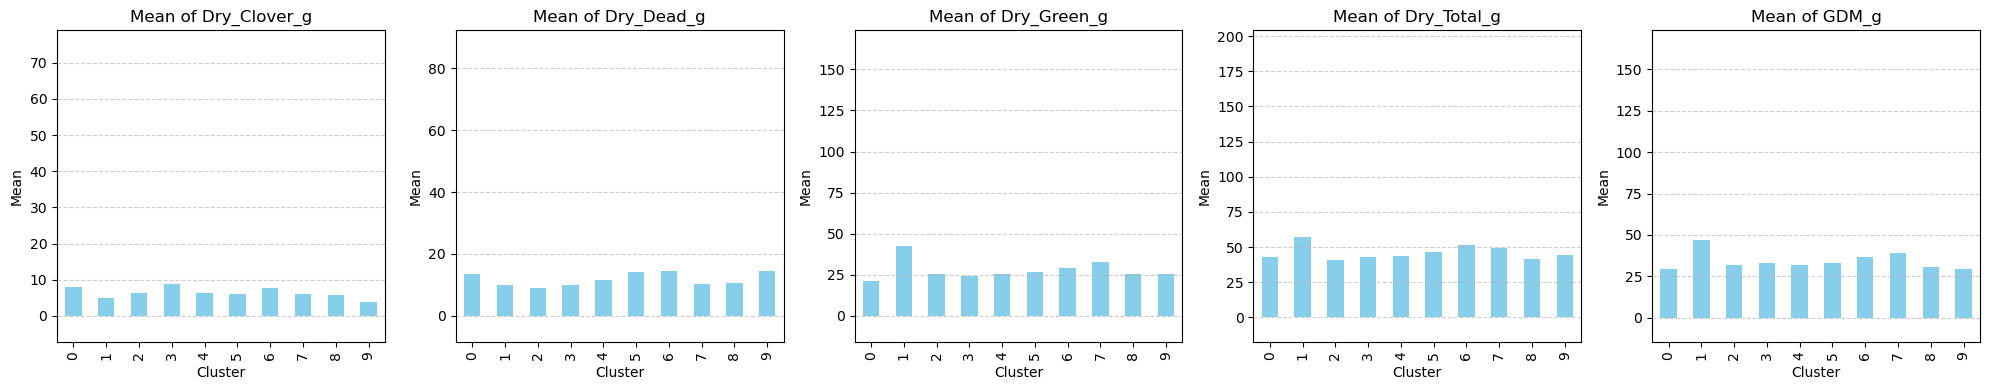

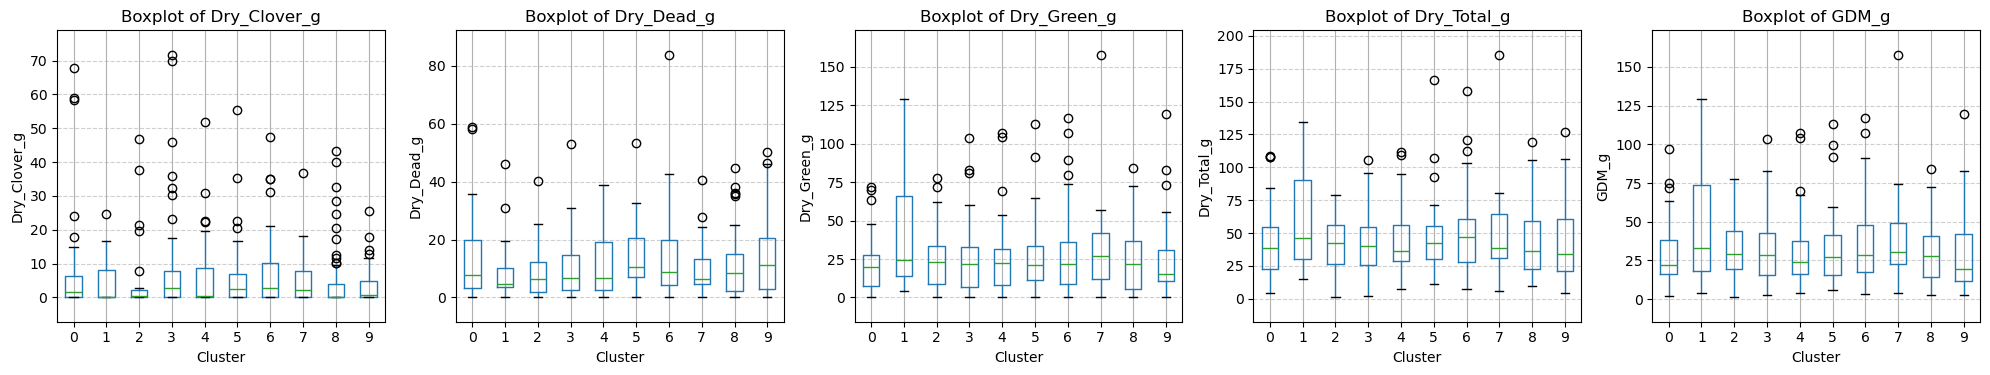

In [29]:
target_cols = [
    'Dry_Clover_g', 'Dry_Dead_g', 'Dry_Green_g',
    'Dry_Total_g', 'GDM_g'
]

# 计算每个指标的最小值和最大值（扩展一点 padding）
y_limits = {}
for col in target_cols:
    col_min = df_train[col].min()
    col_max = df_train[col].max()
    padding = (col_max - col_min) * 0.1  # 10% padding
    y_limits[col] = (col_min - padding, col_max + padding)



fig, axes = plt.subplots(1, len(target_cols), figsize=(20, 4))

for ax, col in zip(axes, target_cols):
    df_train.groupby("color_cluster")[col].mean().plot(
        kind="bar", ax=ax, color="skyblue"
    )
    ax.set_title(f"Mean of {col}", fontsize=12)
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Mean")
    ax.set_ylim(y_limits[col])   # <<< 统一 y 轴高度
    ax.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()




fig, axes = plt.subplots(1, len(target_cols), figsize=(20, 4))

for ax, col in zip(axes, target_cols):
    df_train.boxplot(column=col, by="color_cluster", ax=ax)
    ax.set_title(f"Boxplot of {col}")
    ax.set_xlabel("Cluster")
    ax.set_ylabel(col)
    ax.set_ylim(y_limits[col])   # <<< 统一 y 轴高度
    ax.grid(axis='y', linestyle='--', alpha=0.6)

plt.suptitle("")  # 移除 pandas 默认标题
plt.tight_layout()
plt.show()





<Figure size 1000x600 with 0 Axes>

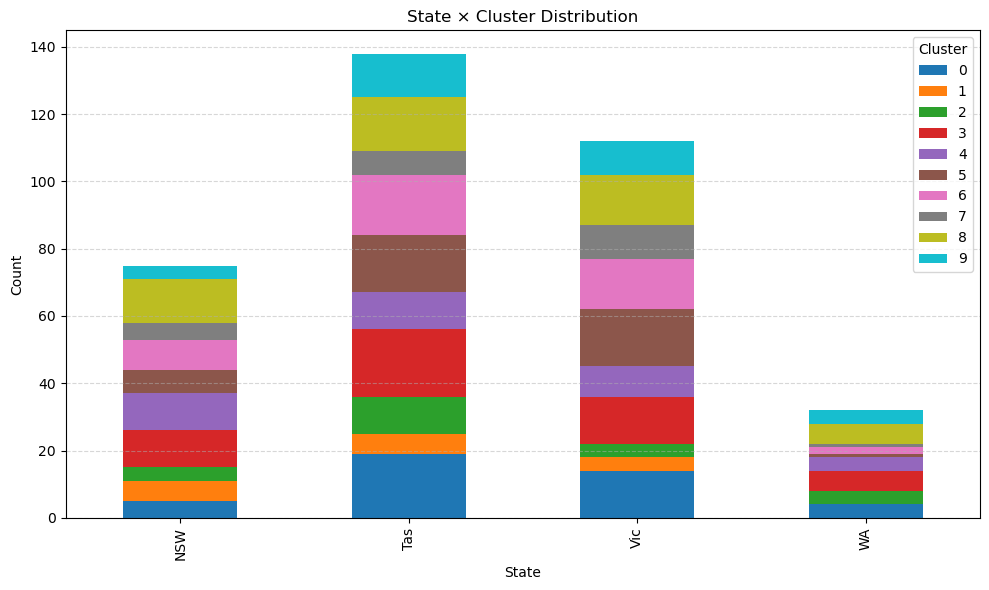

In [30]:
plt.figure(figsize=(10,6))
state_cluster = pd.crosstab(df_train["State"], df_train["color_cluster"])
state_cluster.plot(kind="bar", stacked=True, figsize=(10,6))

plt.title("State × Cluster Distribution")
plt.xlabel("State")
plt.ylabel("Count")
plt.legend(title="Cluster")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


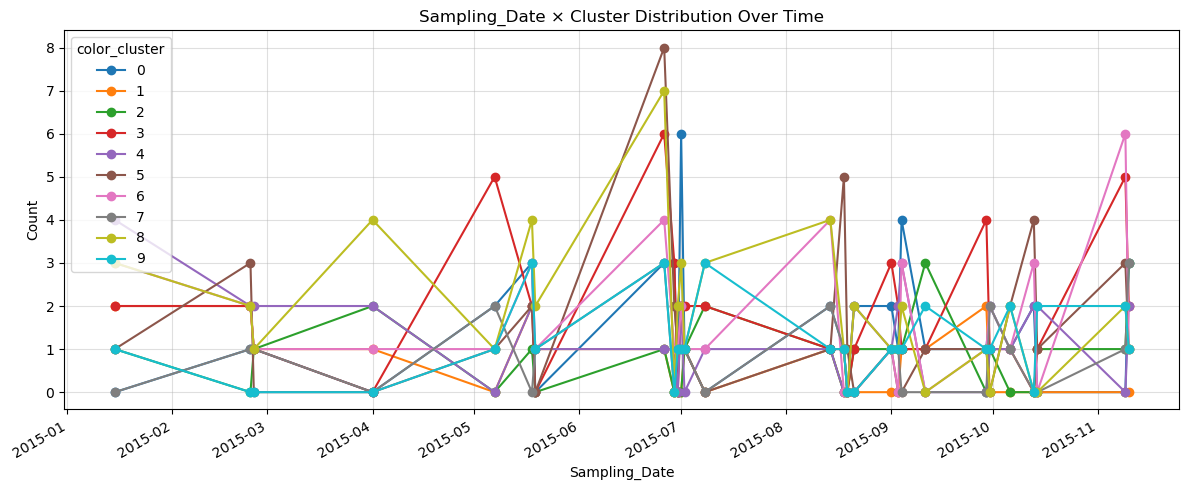

In [31]:
df = df_train.copy()
df["Sampling_Date"] = pd.to_datetime(df["Sampling_Date"])

daily_cluster = pd.crosstab(df["Sampling_Date"], df["color_cluster"])

daily_cluster.sort_index().plot(
    kind="line", figsize=(12,5), marker="o"
)

plt.title("Sampling_Date × Cluster Distribution Over Time")
plt.xlabel("Sampling_Date")
plt.ylabel("Count")
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()


In [32]:
import plotly.express as px

fig = px.scatter_3d(
    df_train,
    x="Dry_Clover_g",
    y="Dry_Dead_g",
    z="Dry_Green_g",
    color="color_cluster",       # 注意：使用颜色聚类
    opacity=0.75,
    title="Biomass Space Colored by Color Clusters",
    color_continuous_scale="Viridis"
)

fig.update_traces(marker=dict(size=4, opacity=0.7))

fig.update_layout(
    width=900,
    height=650,
    scene=dict(
        xaxis_title="Dry Clover (g)",
        yaxis_title="Dry Dead (g)",
        zaxis_title="Dry Green (g)"
    )
)

fig.show()


##### 元数据进行分组

In [ ]:
import numpy as np

biomass_cols = ['Dry_Clover_g', 'Dry_Dead_g', 'Dry_Green_g']
X = df_train[biomass_cols].values
print("Feature shape:", X.shape)


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [ ]:
from sklearn.cluster import KMeans

k = 8
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(X_scaled)

df_train["biomass_cluster"] = labels
print("Clusters:", np.unique(labels))


In [ ]:
import shutil
from pathlib import Path

out_root = root / "biomass_clusters"
out_root.mkdir(exist_ok=True)

for c in np.unique(labels):
    (out_root / f"cluster_{c}").mkdir(exist_ok=True)

for p, lab in zip(img_paths, labels):
    dst = out_root / f"cluster_{lab}" / Path(p).name
    shutil.copy(p, dst)

print("Saved images to biomass_clusters/")


In [ ]:
import plotly.express as px
import plotly.io as pio

# 如果你希望始终在浏览器显示，可以解开下面这句
# pio.renderers.default = "browser"

fig = px.scatter_3d(
    df_train,
    x="Dry_Clover_g",
    y="Dry_Dead_g",
    z="Dry_Green_g",
    color="biomass_cluster",
    color_continuous_scale="Viridis",   # 优雅配色
    opacity=0.7,                        # 透明度，避免点重叠
    title="Interactive 3D Biomass-Space Clustering",
)

# --- 🎨 优化 marker（关键） ---
fig.update_traces(
    marker=dict(
        size=4,         # 点的大小（默认 8 → 改成 4 更专业）
        opacity=0.75,   # 透明度（0.5~0.8 都不错）
    )
)

# --- 🎨 优化图形布局 ---
fig.update_layout(
    width=900,
    height=700,
    scene=dict(
        xaxis_title="Dry Clover (g)",
        yaxis_title="Dry Dead (g)",
        zaxis_title="Dry Green (g)",

        # 背景亮度降低，使点更突出
        bgcolor="white",      

        # 优化网格线密度
        xaxis=dict(gridcolor="lightgray", zerolinecolor="gray"),
        yaxis=dict(gridcolor="lightgray", zerolinecolor="gray"),
        zaxis=dict(gridcolor="lightgray", zerolinecolor="gray"),
    ),

    # 标题格式
    title=dict(
        x=0.5,
        font=dict(size=20)
    )
)

fig.show()


##### 物种划分

In [ ]:
df_train = load_and_prepare_train_df().copy()

print("🌿 Cleaning species names ...")
df_train["Species"] = df_train["Species"].astype(str).str.lower().str.strip()

# --- 按下划线分割，并展开 ---
all_species = (
    df_train["Species"]
    .str.split("_")         # 分割
    .explode()              # 展开成新行
    .str.strip()            # 去空格
)

# --- 统计出现次数 ---
species_counts = (
    all_species.value_counts()
    .reset_index()
    .rename(columns={"index": "Species", "Species": "Count"})
)

print("\n📊 Species frequency:")
print(species_counts)


In [ ]:
df_train["Species"]

In [ ]:
df_train[df_train["ID"] == "ID431471530"]

In [ ]:
df_train = load_and_prepare_train_df().copy()
df_train["Species"] = df_train["Species"].astype(str).str.lower().str.strip()

# 目标根目录
out_root = root / "species_clusters"
# 如果存在，先删除整个目录（包括所有子文件夹 & 文件）
if out_root.exists():
    print(f"⚠️ 目录已存在，删除: {out_root}")
    shutil.rmtree(out_root)

# 重新创建干净目录
out_root.mkdir(parents=True, exist_ok=True)

out_root.mkdir(exist_ok=True)

# group_-1 放所有图片
group_minus1_dir = out_root / "group_-1"
group_minus1_dir.mkdir(exist_ok=True)



print("📥 将所有图片先放入 group_-1 ...")
for img_path in img_paths:
    img_path = Path(img_path)
    dst = group_minus1_dir / img_path.name
    shutil.copy(img_path, dst)

print("✔ 所有图片已放入 group_-1")





In [ ]:
def is_first_two_species_clover(species_str):
    parts = species_str.split("_")

    # 没有物种
    if len(parts) == 0:
        return False

    # 检查第一个
    if "clover" in parts[0]:
        return True

    # # 检查第二个（如果存在）
    # if len(parts) > 1 and "clover" in parts[1]:
    #     return True
    
    
    # # 检查第二个（如果存在）
    # if len(parts) > 2 and "clover" in parts[2]:
    #     return True

    return False



# 初始化所有为 -1
df_train["species_group"] = -1

# Step 1: Clover 分类
mask_clover = df_train["Species"].apply(is_first_two_species_clover)
df_train.loc[mask_clover, "species_group"] = 1

print("第一组数量：", mask_clover.sum())




# 创建 group_1 文件夹
group_1_dir = out_root / "group_1"
group_1_dir.mkdir(exist_ok=True)

# 找出 group_1 图片
df_group1 = df_train[df_train["species_group"] == 1]

print(f"🔎 Group 1（clover 类）图片数量: {len(df_group1)}")

for img_path in df_group1["image_path"]:
    img_path = Path(img_path)
    src = group_minus1_dir / img_path.name
    dst = group_1_dir / img_path.name

    if src.exists():
        shutil.move(src, dst)

print(f"✔ Group 1 的图片已从 group_-1 移到 group_1")





In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
df_train.boxplot(column="Dry_Clover_g", by="species_group")
plt.title("Dry Clover Distribution by Species Group")
plt.suptitle("")
plt.xlabel("Species Group")
plt.ylabel("Dry Clover (g)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
df_train.boxplot(column="Dry_Clover_g", by="species_group")
plt.title("Dry Clover Distribution by Species Group")
plt.suptitle("")
plt.xlabel("Species Group")
plt.ylabel("Dry Clover (g)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()
